**Import libraries and first datasets**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
FOLDER_BA = './BeerAdvocate/'
beers_ba = pd.read_csv(FOLDER_BA + 'beers.csv')
breweries_ba = pd.read_csv(FOLDER_BA + 'breweries.csv')
users_ba = pd.read_csv(FOLDER_BA + 'users.csv')

FOLDER_RB = './RateBeer/'
beers_rb = pd.read_csv(FOLDER_RB + 'beers.csv')
breweries_rb = pd.read_csv(FOLDER_RB + 'breweries.csv')
users_rb = pd.read_csv(FOLDER_RB + 'users.csv')

**Convert from .txt to .csv for 'ratings' datasets (if already done, switch directly to 'Load the cached data')**

In [5]:
def text_to_df (file_path):

    # Liste pour garder les dictionnaires de chaque bière
    beers_dic = []

    # Un dictionnaire temporaire pour stocker les données de chaque bière
    current_beer = {}

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Divise la ligne en utilisant le premier deux-points trouvé
            parts = line.split(':', 1)
            if len(parts) == 2:
                key = parts[0].strip()
                value = parts[1].strip()
                # Ajoute / met à jour la clé dans le dictionnaire de la bière actuelle
                current_beer[key] = value
            # Si vous rencontrez une ligne vide, cela signifie la fin d'un enregistrement de bière
            if line.strip() == '':
                beers_dic.append(current_beer)
                current_beer = {}

    # Assurez-vous d'ajouter la dernière bière si le fichier ne se termine pas par une ligne vide
    if current_beer:
        beers_dic.append(current_beer)

# Créer un DataFrame à partir de la liste des dictionnaires de bières
    return pd.DataFrame(beers_dic)

In [7]:
ratings_ba = text_to_df(FOLDER_BA + 'ratings.txt')

In [9]:
ratings_ba.to_csv(FOLDER_BA + 'ratings_ba_clean.csv')

In [9]:
ratings_rb.to_csv(FOLDER_RB + 'ratings_rb_clean.csv')

**Load the newly created .csv**

In [7]:
ratings_ba_csv = pd.read_csv(FOLDER_BA + 'ratings_ba_clean.csv')

In [3]:
ratings_rb_csv = pd.read_csv(FOLDER_RB + 'ratings_rb_clean.csv')

**Try to cache the data**

In [8]:
pickle.dump(ratings_ba_csv, open('ratings_ba.pkl', 'wb'))

In [4]:
pickle.dump(ratings_rb_csv, open('ratings_rb.pkl', 'wb'))

### Load the cached data

In [4]:
ratings_ba = pickle.load(open('ratings_ba.pkl', 'rb'))

In [5]:
ratings_rb = pickle.load(open('ratings_rb.pkl', 'rb'))

**Merge Reviews and users to get location**

In [6]:
user_ratings_ba = users_ba.merge(ratings_ba, how = 'right', on = 'user_id')
user_ratings_rb = users_rb.merge(ratings_rb, how = 'right', on = 'user_id')

In [7]:
print(user_ratings_ba.shape, user_ratings_rb.shape)

(8393032, 23) (7123806, 21)


In [8]:
user_ratings_ba['date'] = pd.to_datetime(user_ratings_ba['date'], unit='s')
user_ratings_rb['date'] = pd.to_datetime(user_ratings_rb['date'], unit='s')

In [9]:
user_ratings_ba['date']

0         2015-08-20 10:00:00
1         2009-02-20 11:00:00
2         2006-03-13 11:00:00
3         2004-12-01 11:00:00
4         2004-08-30 10:00:00
                  ...        
8393027   2006-02-27 11:00:00
8393028   2006-02-19 11:00:00
8393029   2004-08-10 10:00:00
8393030   2012-07-08 10:00:00
8393031   2006-02-19 11:00:00
Name: date, Length: 8393032, dtype: datetime64[ns]

In [12]:
user_ratings_ba['month'] = user_ratings_ba['date'].dt.month
user_ratings_ba['year'] = user_ratings_ba['date'].dt.year
user_ratings_rb['month'] = user_ratings_rb['date'].dt.month
user_ratings_rb['year'] = user_ratings_rb['date'].dt.year

In [13]:
user_ratings_ba['year_month'] = user_ratings_ba['date'].dt.to_period('M')
user_ratings_rb['year_month'] = user_ratings_rb['date'].dt.to_period('M')

### Compare RateBeers and BeerAdvocate: where do the reviews come from?

**Which columns have missing values?**

In [37]:
user_ratings_ba.isna().any()

nbr_ratings     False
nbr_reviews     False
user_id         False
user_name_x      True
joined          False
location        False
Unnamed: 0      False
beer_name       False
beer_id         False
brewery_name    False
brewery_id      False
style           False
abv              True
date            False
user_name_y      True
appearance       True
aroma            True
palate           True
taste            True
overall          True
rating          False
text             True
review          False
month           False
year            False
year_month      False
country         False
dtype: bool

In [35]:
user_ratings_rb.isna().any()

nbr_ratings     False
user_id         False
user_name_x     False
joined          False
location        False
Unnamed: 0      False
beer_name       False
beer_id         False
brewery_name    False
brewery_id      False
style           False
abv              True
date            False
user_name_y     False
appearance      False
aroma           False
palate          False
taste           False
overall         False
rating          False
text             True
month           False
year            False
year_month      False
country         False
dtype: bool

**Drop NaN for location -> remove reviews where location is not mentioned**

In [14]:
missing_values_location_ba = 100 * user_ratings_ba['location'].isna().sum() / user_ratings_ba.shape[0]
missing_values_location_rb = 100 * user_ratings_rb['location'].isna().sum() / user_ratings_rb.shape[0]

In [15]:
print(f"users_ratings_ba has {missing_values_location_ba:.2f}% missing values in location")
print(f"users_ratings_rb has {missing_values_location_rb:.2f}% missing values in location")

users_ratings_ba has 5.96% missing values in location
users_ratings_rb has 2.86% missing values in location


In [16]:
user_ratings_ba = user_ratings_ba.dropna(subset='location')
user_ratings_rb = user_ratings_rb.dropna(subset='location')

**New column: country, to remove states in USA**

In [17]:
def extract_country(location):
    if ',' in location:
        # If there is a comma in the location, split the string and take the first part
        return location.split(',')[0].strip()
    else:
        # If there is no comma, return the original location
        return location.strip()

In [18]:
user_ratings_ba['country'] = user_ratings_ba['location'].apply(extract_country)
user_ratings_rb['country'] = user_ratings_rb['location'].apply(extract_country)

**Plot contribution of different countries in the % of reviews in Beer Advocate and RateBeer**

In [19]:
by_country_ba = (user_ratings_ba.groupby('country')['rating'].count()*100 / user_ratings_ba.shape[0]).sort_values(ascending=False)
by_country_rb = (user_ratings_rb.groupby('country')['rating'].count()*100 / user_ratings_rb.shape[0]).sort_values(ascending =False)
top_20_countries_ba = by_country_ba.nlargest(20)
top_20_countries_rb = by_country_rb.nlargest(20)

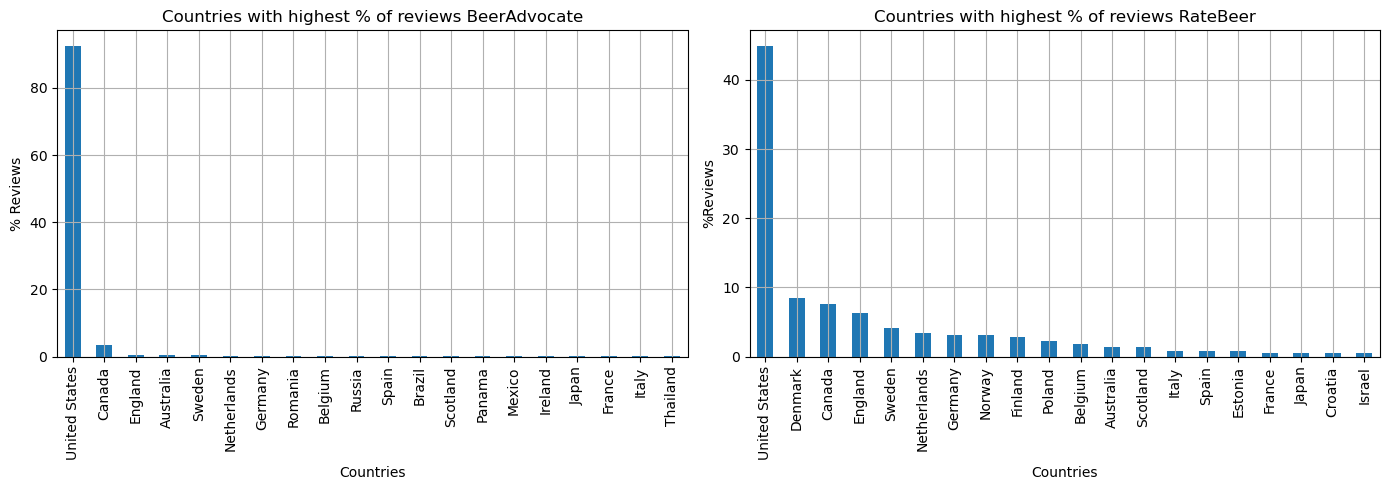

In [20]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize = (14,5))

top_20_countries_ba.plot(kind='bar', ax = axes[0])
axes[0].set_xlabel('Countries')
axes[0].set_ylabel('% Reviews')
axes[0].set_title('Countries with highest % of reviews BeerAdvocate')

top_20_countries_rb.plot(kind='bar', ax = axes[1])
axes[1].set_xlabel('Countries')
axes[1].set_ylabel('%Reviews')
axes[1].set_title('Countries with highest % of reviews RateBeer')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

**What is the most reviewed style the whole world (in RateBeer)?**

In [21]:
beer_style_counts = user_ratings_rb.groupby('style')['style'].agg('count')

In [22]:
beer_style_counts = beer_style_counts.sort_values (ascending=False)

In [23]:
top_20_beer_style = beer_style_counts.head(20)

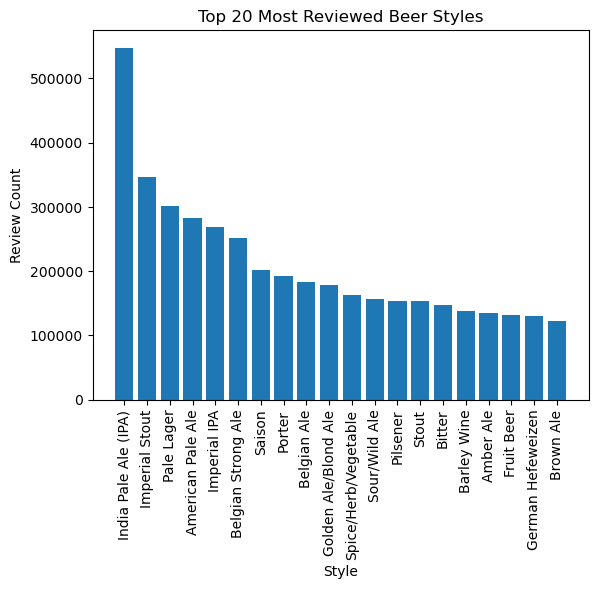

In [30]:
plt.bar(top_20_beer_style.index, top_20_beer_style.values)
plt.xlabel('Style')
plt.ylabel('Review Count')
plt.title('Top 20 Most Reviewed Beer Styles')
plt.xticks(rotation=90)
plt.show()

**...and in BeerAdvocate?**

In [25]:
beer_style_counts_ba = user_ratings_ba.groupby('style')['style'].agg('count')

In [26]:
beer_style_counts_ba = beer_style_counts_ba.sort_values (ascending=False)

In [27]:
top_20_beer_style_ba = beer_style_counts_ba.head(20)

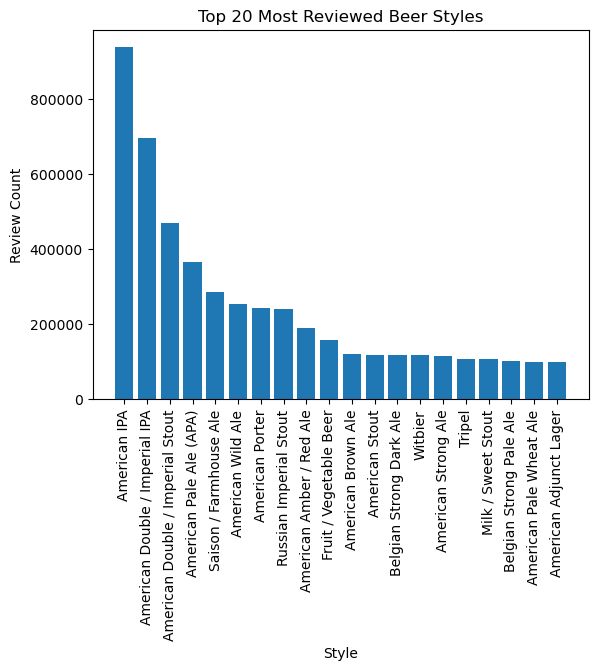

In [32]:
plt.bar(top_20_beer_style_ba.index, top_20_beer_style_ba.values)
plt.xlabel('Style')
plt.ylabel('Review Count')
plt.title('Top 20 Most Reviewed Beer Styles')
plt.xticks(rotation=90)
plt.show()

**Most reviewed in RateBeers but only in the US**

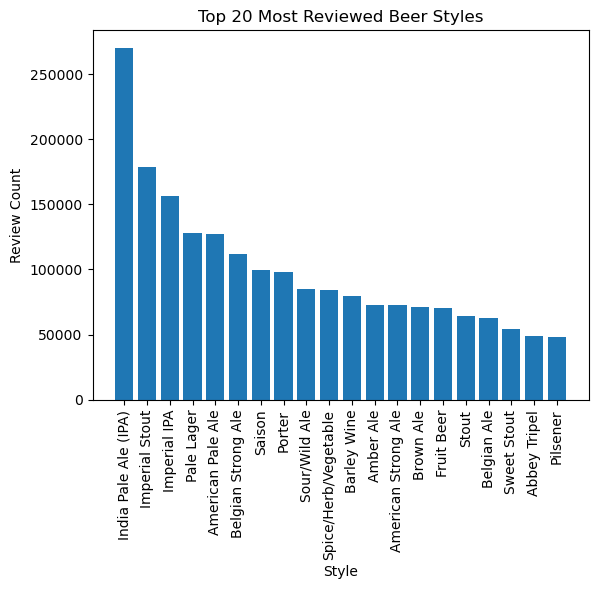

In [50]:
plt.bar(top_20_beer_style_rb_us.index, top_20_beer_style_rb_us.values)
plt.xlabel('Style')
plt.ylabel('Review Count')
plt.title('Top 20 Most Reviewed Beer Styles')
plt.xticks(rotation=90)
plt.show()

In [46]:
beer_style_counts_rb_us = user_ratings_rb[user_ratings_rb['country'] == 'United States'].groupby('style')['style'].agg('count')

In [47]:
beer_style_counts_rb_us

style
Abbey Dubbel               30815
Abbey Tripel               48680
Abt/Quadrupel              31862
Altbier                    14951
Amber Ale                  72614
                           ...  
Traditional Ale            11923
Weizen Bock                13770
Wheat Ale                  44995
Witbier                    46664
Zwickel/Keller/Landbier     7561
Name: style, Length: 90, dtype: int64

In [48]:
beer_style_counts_rb_us = beer_style_counts_rb_us.sort_values (ascending=False)

In [49]:
top_20_beer_style_rb_us = beer_style_counts_rb_us.head(20)

**Distribution of reviews per month for all beers**

In [155]:
all_beer_all_world = user_ratings_rb[
    (user_ratings_rb['year'] >= 2010) &
    (user_ratings_rb['year'] <= 2016)
]

In [156]:
all_beer_reviews_all_world = all_beer_all_world.groupby('year_month')["rating"].count()

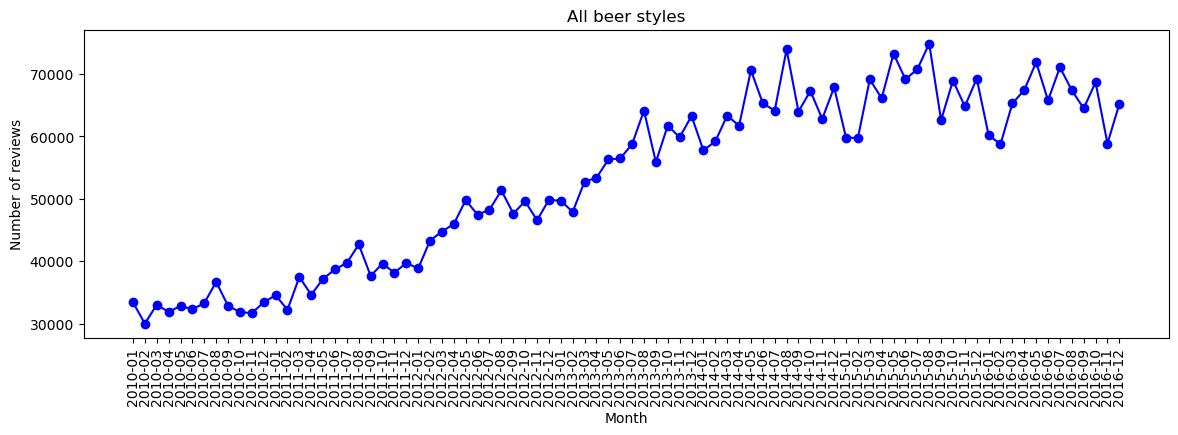

In [183]:
plt.figure(figsize = (14,4))
plt.plot(all_beer_reviews_all_world.index.astype(str), all_beer_reviews_all_world.values, marker = 'o', color = 'blue')
plt.xlabel('Month')
plt.ylabel('Number of reviews')
plt.title('All beer styles')
plt.xticks(rotation = 90)
#plt.ylim(0,75000)
plt.show()

**Distribution of IPA reviews normalized according to total number of reviews**

In [158]:
ipa_all_world = all_beer_all_world[(all_beer_all_world['style'] == 'India Pale Ale (IPA)')]

In [159]:
ipa_reviews_per_month_all_world = ipa_all_world.groupby('year_month')["rating"].count()

In [160]:
ipa_reviews_perc = ipa_reviews_per_month_all_world / all_beer_reviews_all_world

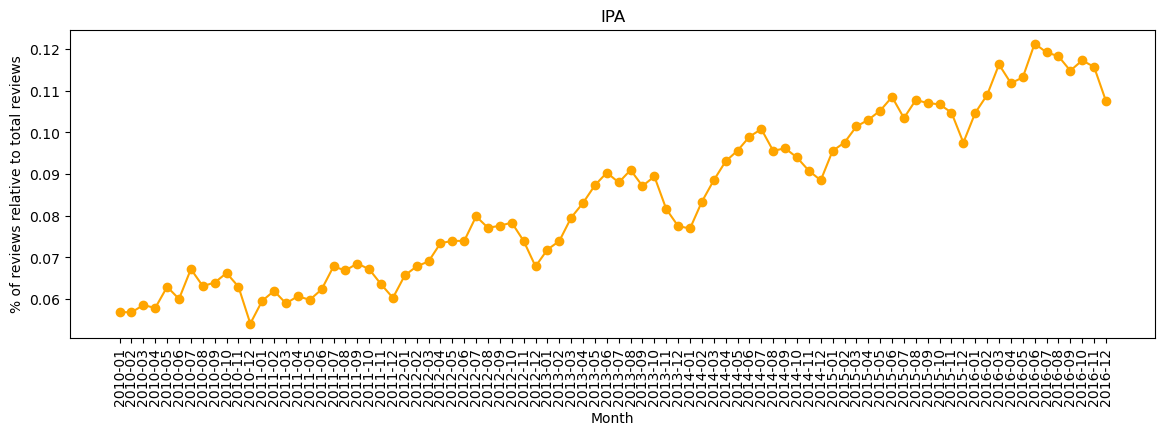

In [161]:
plt.figure(figsize = (14,4))
plt.plot(ipa_reviews_perc.index.astype(str), ipa_reviews_perc.values, marker = 'o', color = 'orange')
plt.xlabel('Month')
plt.ylabel('% of reviews relative to total reviews')
plt.title('IPA')
plt.xticks(rotation = 90)
plt.show()

**Same thing for Pilsener**

In [164]:
pilsener = all_beer_all_world[(all_beer_all_world['style'] == 'Pilsener')]

In [166]:
pilsener_per_month_all_world = pilsener.groupby('year_month')["rating"].count()

In [167]:
pilsener_reviews_perc = pilsener_per_month_all_world / all_beer_reviews_all_world

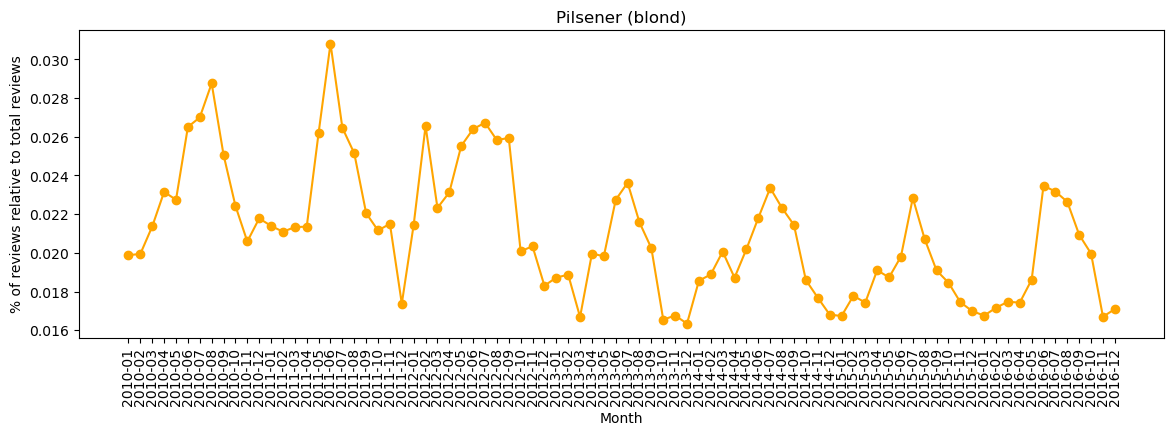

In [169]:
plt.figure(figsize = (14,4))
#plt.plot(pilsener_reviews_per_month.index.astype(str), pilsener_reviews_per_month.values, marker = 'o')
plt.plot(pilsener_reviews_perc.index.astype(str), pilsener_reviews_perc.values, marker = 'o', color = 'orange')
plt.xlabel('Month')
plt.ylabel('% of reviews relative to total reviews')
plt.title('Pilsener (blond)')
plt.xticks(rotation = 90)
plt.show()

**Belgian Strong Ale**

In [179]:
belg_strong_ale = all_beer_all_world[(all_beer_all_world['style'] == 'Belgian Strong Ale')]

In [180]:
belg_strong_ale_per_month_all_world = belg_strong_ale.groupby('year_month')["rating"].count()

In [181]:
belg_strong_ale_reviews_perc = belg_strong_ale_per_month_all_world / all_beer_reviews_all_world

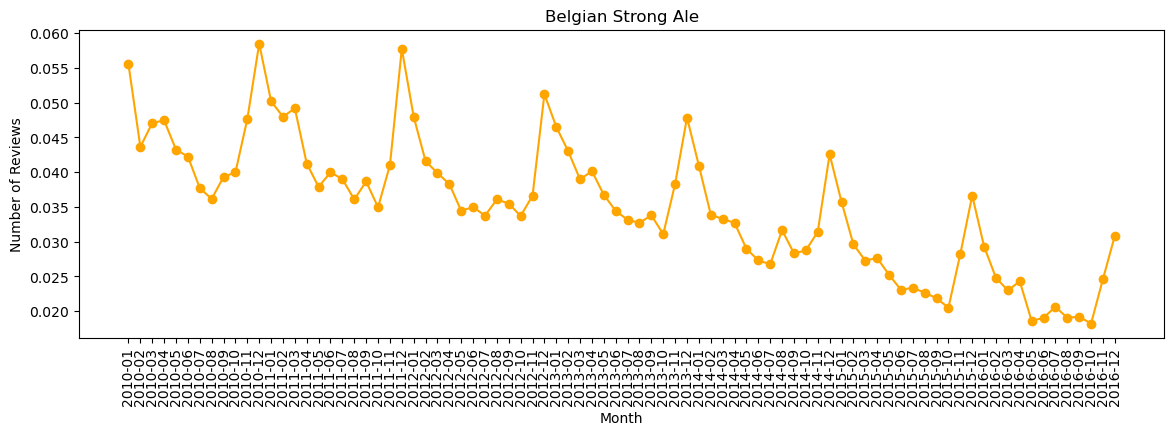

In [182]:
plt.figure(figsize = (14,4))
#plt.plot(belg_strong_ale_reviews_per_month.index.astype(str), belg_strong_ale_reviews_per_month.values, marker = 'o')
plt.plot(belg_strong_ale_reviews_perc.index.astype(str), belg_strong_ale_reviews_perc.values, marker = 'o', color = 'orange')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Belgian Strong Ale')
plt.xticks(rotation = 90)
plt.show()

**Distribution of alcohol degree among beers compared to reviews -> do people drink a lot of strong beers? (RateBeer only)**

In [62]:
user_ratings_less_15_rb = user_ratings_rb[user_ratings_rb['abv'] <= 15]

In [65]:
beers_less_15_rb = beers_rb[beers_rb['abv'] <= 15]

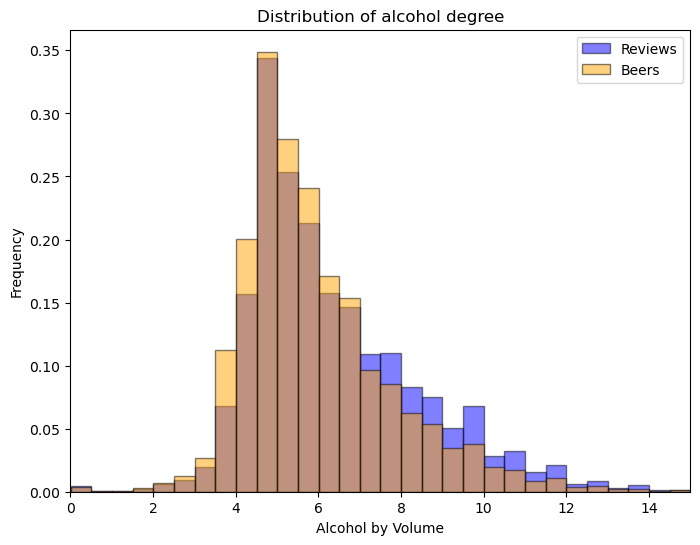

In [74]:
plt.figure(figsize = (8,6))
plt.hist(user_ratings_less_15_rb['abv'], bins = 30, color = 'blue', label = 'Reviews', density = True, alpha = 0.5, edgecolor = 'black')
plt.hist(beers_less_15_rb['abv'], bins = 30, color = 'orange', label = 'Beers', density = True, alpha = 0.5, edgecolor = 'black')
plt.xlabel('Alcohol by Volume')
plt.ylabel('Frequency')
plt.title('Distribution of alcohol degree')
plt.xlim(0,15)
plt.legend()
plt.show()

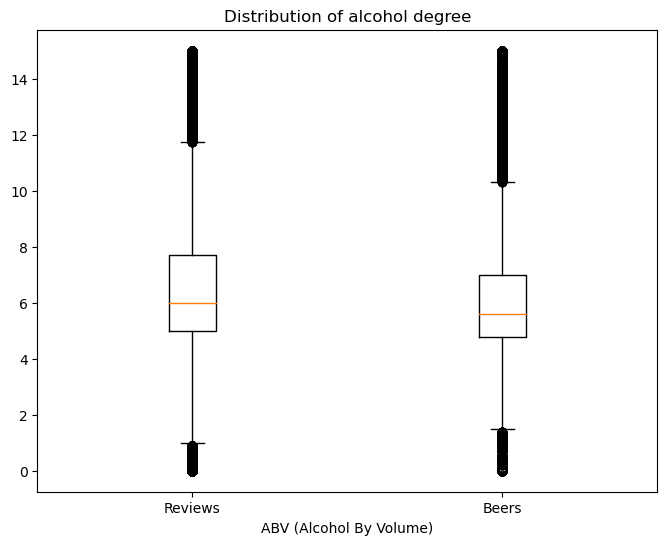

In [85]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.boxplot([user_ratings_less_15_rb['abv'], beers_less_15_rb['abv']], labels=['Reviews', 'Beers'])
plt.title('Distribution of alcohol degree')
plt.xlabel('ABV (Alcohol By Volume)')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.boxplot([user_ratings_less_15_rb['abv'], beers_less_15_rb['abv']], labels=['Reviews', 'Beers'])
plt.title('Distribution of alcohol degree')
plt.xlabel('ABV (Alcohol By Volume)')
plt.show()

In [93]:
pils = beers_less_15_rb[beers_less_15_rb['style'] == 'Pilsener']
bsa = beers_less_15_rb[beers_less_15_rb['style'] == 'Belgian Strong Ale']

In [94]:
pils

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
55,526621,Boundary Generic,22818,Boundary,Pilsener,1,NaN,NaN,2.89,5.0,2.800000,NaN,0,NaN
214,360989,Mourne Mountains Mourne Mist,23165,Mourne Mountains Brewery,Pilsener,1,NaN,NaN,3.00,4.5,3.300000,-0.412028,1,3.3
255,368965,Walled City Kicks,24866,Walled City,Pilsener,1,NaN,NaN,3.00,4.1,3.300000,NaN,0,NaN
303,457548,AdstraGold Oaky Pilsner Premium,15008,AdstraGold Microbrewery & Bistro Bar,Pilsener,2,NaN,NaN,2.81,3.5,2.600000,NaN,0,NaN
304,224981,AdstraGold Pilsner Premium,15008,AdstraGold Microbrewery & Bistro Bar,Pilsener,5,NaN,NaN,2.78,3.0,2.220000,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442051,73708,Korça Bjonde,8244,Birra Korça,Pilsener,95,4.0,6.0,2.11,4.5,2.081053,NaN,0,NaN
442064,349608,Deutch Beer,23853,Hyseni sh.p.k.,Pilsener,1,NaN,NaN,2.72,4.5,2.000000,NaN,0,NaN
442065,439458,Birra King Pils,28180,Shoqeria Picana,Pilsener,2,NaN,NaN,3.02,4.6,3.200000,NaN,0,NaN
442075,287791,Stela Pils 4%,1107,Stefani & Co,Pilsener,17,3.0,2.0,1.92,4.0,1.705882,NaN,0,NaN


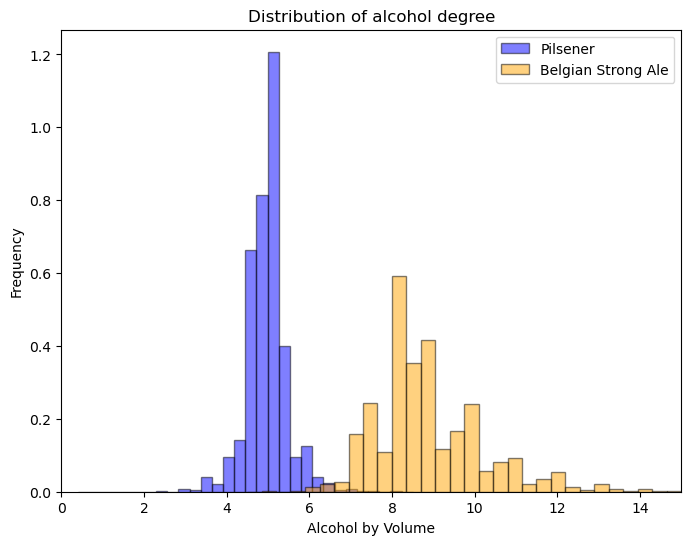

In [96]:
plt.figure(figsize = (8,6))
plt.hist(pils['abv'], bins = 30, color = 'blue', label = 'Pilsener', density = True, alpha = 0.5, edgecolor = 'black')
plt.hist(bsa['abv'], bins = 30, color = 'orange', label = 'Belgian Strong Ale', density = True, alpha = 0.5, edgecolor = 'black')
plt.xlabel('Alcohol by Volume')
plt.ylabel('Frequency')
plt.title('Distribution of alcohol degree')
plt.xlim(0,15)
plt.legend()
plt.show()

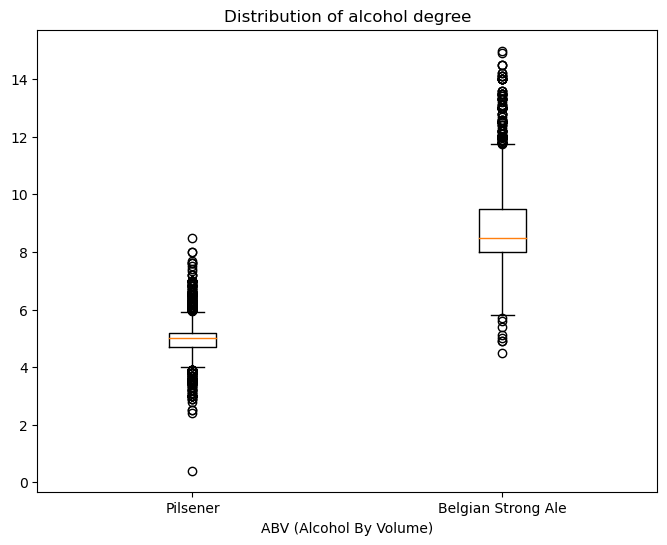

In [95]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.boxplot([pils['abv'], bsa['abv']], labels=['Pilsener', 'Belgian Strong Ale'])
plt.title('Distribution of alcohol degree')
plt.xlabel('ABV (Alcohol By Volume)')
plt.show()